In [ ]:
#My own attempts at code, make sure to update the kaggle
pip install contractions

In [ ]:
pip install pyLDAvis

In [472]:
pip install textblob


  Obtaining dependency information for textblob from https://files.pythonhosted.org/packages/1e/d6/40aa5aead775582ea0cf35870e5a3f16fab4b967f1ad2debe675f673f923/textblob-0.19.0-py3-none-any.whl.metadata
  Obtaining dependency information for nltk>=3.9 from https://files.pythonhosted.org/packages/4d/66/7d9e26593edda06e8cb531874633f7c2372279c3b0f46235539fe546df8b/nltk-3.9.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   ----------- ---------------------------- 174.1/624.3 kB 3.5 MB/s eta 0:00:01
   ------------------------------ --------- 481.3/624.3 kB 6.0 MB/s eta 0:00:01
   ---------------------------------------- 624.3/624.3 kB 4.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   -------- ------------------------------- 0.3/1.5 MB 6.3 MB/s eta 0:00:01
   ------------------ --------------------- 0.7/1.5 MB 8.8 MB/s eta 0:00:01
   --------------------------- ------------ 1.0/1.5 MB 8.1 MB/s eta

In [2]:
import sqlite3

# creating file path
dbfile = 'IMDB_Movies_2021.db'

import pandas as pd
import sqlite3
import sqlalchemy 

try:
    conn = sqlite3.connect(dbfile)    
except Exception as e:
    print(e)

#Now in order to read in pandas dataframe we need to know table name
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(f"Table_Name : {cursor.fetchall()}")

df = pd.read_sql_query('SELECT * FROM reviews', conn)
conn.close()

C:\Users\Matthew\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Table_Name : [('REVIEWS',), ('sqlite_sequence',)]


In [3]:
for i in df['REVIEW']:
    #print(' ' )
    #print(i)
    if type(i) != str:
        print(i)
#for i in df['RATING']:
    #print(' ' )
    #print(i)
    #print(type(i))
df.columns

Index(['ID', 'REVIEW', 'RATING', 'AUTHOR', 'TITLE'], dtype='object')

In [4]:
print(all(isinstance(x, str) for x in df['REVIEW']))
print(all(isinstance(x, float) for x in df['RATING']))
print(all(isinstance(x, str) for x in df['TITLE']))

#So all same type so no adjustments needed

True
True
True


In [5]:
df.isnull().sum()
#So only null values in the rating, how do we deal with this
#We can ignore the rating altogether, or not use it as a pivotol point
#Or remove these from data set (will still have 4900 points)

ID          0
REVIEW      0
RATING    118
AUTHOR      0
TITLE       0
dtype: int64

In [11]:
#Check ratings boundaries
print(min(df['RATING']))
print(max(df['RATING']))
#1-10
#Could potentially just get average for missing data


print( 'pos', len(df[df['RATING']>=7]))
print('negative', len(df[df['RATING']<=3]))
5450-2219 -2014      

1.0
10.0
pos 2219
negative 2014


1217

In [26]:
#One important thing to do in sentiments analysis is remval of punctuation and stop words
import nltk
import string
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Matthew\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Matthew\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [ ]:
#This code removes punctuation and stop words, could use for some type of basic sentiment analysis (OUTDATED)

List_of_seperated = []
indexer = 0
for i in df['REVIEW'].head(1):
    sentence = str(i)
    sentence = ''.join(' ' if c in string.punctuation else c for c in sentence)
    words = sentence.split(' ')
    print(words)
    stop_words = set(stopwords.words("english"))
    filtered_sentence_list = [word for word in words if word.lower() not in stop_words]
    filtered_sentence = " ".join(filtered_sentence_list)
    print(sentence)
    print(filtered_sentence)
    

In [29]:
#New Code


stop_words = set(stopwords.words('english'))
punctuation = str.maketrans('', '', string.punctuation)

# this should be added to when needed
other_words = {"movie",
              "film",
              "cinema",
              "story",
              "character",
              "acting",
              "set",
               "actor",
               "show",
               "director",
               "scene"}
stop_words.update(other_words)

List_of_seperated = []

for i in df['REVIEW'].head(1):
    sentence = str(i)
    sentence = contractions.fix(sentence)
    # sentence = sentence.replace("'", "")
    words = word_tokenize(sentence)
    words = [word.lower() for word in words]
    words = [word.translate(punctuation) for word in words]
    words = [word for word in words if word not in stop_words and word and not word.isdigit()]
    List_of_seperated.append(words)
    
#mAYBE not remove negation stop words( ie: not )    
print(List_of_seperated,df['REVIEW'][0])

[['get', 'terrible', 'reviews', 'especially', 'lots', 'people', 'talk', 'incredible', 'bad', 'special', 'effects', 'oscar', 'worthy', 'terrible', 'quite', 'good', 'type', 'movieit', 'lacks', 'quality', 'script', 'shark', 'little', 'mistakes', 'overall', 'watchable', 'fan', 'genre', 'recommend', 'check', 'oneignore', 'scores', 'unfair', 'work', 'project']] I don't get all the terrible reviews for this movie. Especially because lots of people talk incredible bad of the special effects. It's not Oscar worthy, but is not terrible. It's quite good for such type of movie.It lacks some quality on the script, but which shark movie doesn't?There's some other little mistakes, but overall is watchable. If you are a fan of this genre, o recommend you check it out this one.Ignore the below 4 scores. It's unfair for those who work in this project.


In [30]:
#Trying BOW

List_of_seperated = []
indexer = 0
for i in df['REVIEW']:
    sentence = str(i)
    sentence = ''.join(' ' if c in string.punctuation else c for c in sentence)
    sentence = sentence.strip()
    words = sentence.split(' ')
    for i in words:
        i.replace('\n','')
    stop_words = set(stopwords.words("english"))
    filtered_sentence_list = [word.lower() for word in words if word.lower() not in stop_words] #.lower() so we remove capitalisations
    List_of_seperated.append(filtered_sentence_list)
    filtered_sentence = " ".join(filtered_sentence_list)


In [31]:

vocabulary = set()

# Build the vocabulary
for sentence in List_of_seperated:
    vocabulary.update(sentence)

# Convert to a sorted list
vocabulary = sorted(list(vocabulary))  #Has problem with \n

index2 = 0 
for i in vocabulary:
    vocabulary[index2] = i.replace('\n','')
    index2 += 1

def create_bow_vector(sentence, vocab):
    vector = [0] * len(vocab)  # Initialize a vector of zeros
    for word in sentence:
        if word in vocab:
            idx = vocab.index(word)  # Find the index of the word in the vocabulary
            vector[idx] += 1  # Increment the count at that index
    return vector

vocabulary.index('get')

134

In [32]:
bow_vectors = [create_bow_vector(sentence, vocabulary) for sentence in List_of_seperated]

In [33]:
bow_vectors[0][134]

1

In [ ]:
#There will be a more refined pre processing process, but this s the baseline

In [34]:
#Trying to find topics

In [35]:
#In the topic based sentiment analysis, we need a corpus. This is a set of documents. (ie: this version does not use BOW)

In [342]:
#New Code


stop_words = set(stopwords.words('english'))
punctuation = str.maketrans('', '', string.punctuation)

# this should be added to when needed (i think i need these words)
other_words = {"movie",
              "film",
              "cinema",
              "story",
              "character",
              "acting",
              "set",
               "actor",
               "show",
               "director",
               "scene"}
stop_words.update(other_words)


List_of_seperated = []

for i in df['REVIEW']:
    sentence = str(i)
    sentence = contractions.fix(sentence)
    # sentence = sentence.replace("'", "")
    words = word_tokenize(sentence)
    words = [word.lower() for word in words]
    words = [word.translate(punctuation) for word in words]
    words = [word for word in words if word not in stop_words and word and not word.isdigit()]
    List_of_seperated.append(words)
    
#for i in List_of_seperated:
 #   print(len(i))  

In [424]:
dictionary_of_words = {}   
for i in List_of_seperated:
    for j in i:
        if j in dictionary_of_words:
            dictionary_of_words[j] += 1
        else:
            dictionary_of_words[j] = 1
        
        
for i in List_of_seperated:
    for j in i:
        if dictionary_of_words[j] >10000:
            pass
        else:
            i.remove(j)

In [425]:
for i in List_of_seperated:
    print(len(i))

#Lisr_0f_seperated is my corpus

5
2
21
14
6
27
3
5
11
3
18
4
5
4
2
52
1
6
9
1
5
9
6
8
4
4
4
15
1
22
9
5
10
15
6
1
4
6
5
2
3
4
16
7
4
2
0
17
3
1
4
5
3
7
0
10
7
7
8
2
5
4
9
1
3
5
1
1
13
2
17
6
3
1
1
5
4
1
1
4
4
9
1
1
2
11
9
2
5
5
20
13
5
3
2
9
7
24
20
1
3
6
1
6
3
1
8
3
2
27
2
7
0
1
1
6
1
9
0
4
2
5
8
2
1
32
3
0
13
3
2
4
1
39
6
3
22
7
10
7
18
0
19
1
15
15
13
10
42
2
32
1
1
21
3
6
12
4
5
1
1
4
3
4
8
6
2
19
7
2
16
22
1
4
1
10
16
9
4
7
5
3
3
5
4
2
5
7
5
1
4
6
1
7
7
7
0
1
5
27
20
14
2
12
8
5
10
8
10
4
16
2
3
15
8
7
9
4
23
3
10
8
12
9
3
14
3
14
6
6
3
43
5
6
18
3
4
4
19
4
1
5
8
3
47
16
6
3
20
13
16
8
6
16
5
8
4
29
11
3
14
15
10
29
16
10
10
12
9
22
14
9
26
12
5
16
6
43
9
6
4
14
48
37
27
15
12
33
25
4
4
2
12
16
14
27
8
1
2
16
7
11
3
4
6
6
8
10
4
5
4
1
4
11
5
5
1
3
5
0
3
1
1
4
4
3
7
8
3
0
5
3
12
32
0
9
4
1
6
11
3
3
5
12
2
15
1
69
2
9
8
1
14
24
17
6
2
11
2
24
2
3
3
7
14
1
4
2
4
1
4
49
5
1
6
17
1
4
1
28
3
1
8
2
0
10
1
1
1
5
3
1
2
7
1
2
4
5
2
8
34
42
2
25
49
3
8
120
12
3
10
23
2
2
0
1
1
4
7
7
5
6
39
3
9
8
4
1
3
1
3
7
9
8
11
3
2
4
4


In [426]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
from pprint import pprint

In [427]:
id2word = corpora.Dictionary(List_of_seperated)

In [428]:
texts = List_of_seperated

In [429]:
corpus = [id2word.doc2bow(text) for text in texts]

In [455]:
num_topics = 4

In [456]:
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42, passes=20, alpha="auto", per_word_topics=True)


In [457]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=List_of_seperated, dictionary=id2word, coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence Score:" , coherence_lda)

Coherence Score: 0.6180817443748396


In [60]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [67]:
#try to make work
#pyLDAvis.enable_notebook()
#vis = gensimvis.prepare(lda_model,corpus,id2word)

In [68]:
#Function to test different number of topics

def lda_diff_topic(num_topics):
    num_topics = num_topics
    lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42, passes=10, alpha="auto", per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=List_of_seperated, dictionary=id2word, coherence="c_v")
    coherence_lda = coherence_model_lda.get_coherence()
    return (coherence_lda)


In [75]:
coherences = []

for i in range(10,30,4):
    score = lda_diff_topic(i)
    coherences.append(score)

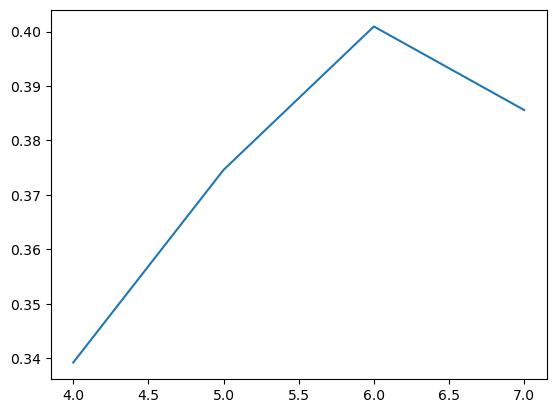

In [84]:
import matplotlib.pyplot as plt

plt.plot([4,5,6,7],coherences)
plt.show()

In [85]:
#See maximum at 6 topics

In [458]:
#So we now have our topics, and main words in their topics
pprint(lda_model.print_topics())

[(0,
  '0.023*"bad" + 0.022*"watch" + 0.012*"would" + 0.009*"time" + 0.009*"action" '
  '+ 0.007*"nothing" + 0.006*"one" + 0.005*"get" + 0.005*"clancy" + '
  '0.005*"good"'),
 (1,
  '0.044*"like" + 0.034*"good" + 0.022*"great" + 0.022*"even" + 0.021*"time" + '
  '0.019*"see" + 0.017*"one" + 0.017*"could" + 0.016*"would" + 0.015*"watch"'),
 (2,
  '0.028*"one" + 0.024*"movies" + 0.019*"good" + 0.019*"like" + 0.017*"bad" + '
  '0.013*"get" + 0.012*"time" + 0.012*"watch" + 0.011*"really" + '
  '0.010*"could"'),
 (3,
  '0.030*"one" + 0.029*"would" + 0.028*"really" + 0.021*"like" + '
  '0.020*"characters" + 0.020*"well" + 0.017*"much" + 0.014*"even" + '
  '0.013*"good" + 0.011*"could"')]


In [459]:
import numpy as np

print(lda_model[corpus[1]][0])
    
len(List_of_seperated[1])

[(0, 0.0239541), (1, 0.895116), (2, 0.035412315), (3, 0.045517642)]


2

In [460]:
x= lda_model.show_topics(num_topics= num_topics, num_words=10,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Topics and Words
for topic,words in topics_words:
    print(str(topic)+ "::"+ str(words))
print()

0::['bad', 'watch', 'would', 'time', 'action', 'nothing', 'one', 'get', 'clancy', 'good']
1::['like', 'good', 'great', 'even', 'time', 'see', 'one', 'could', 'would', 'watch']
2::['one', 'movies', 'good', 'like', 'bad', 'get', 'time', 'watch', 'really', 'could']
3::['one', 'would', 'really', 'like', 'characters', 'well', 'much', 'even', 'good', 'could']



In [ ]:
#And then we would get the sentiment of the 5 topics 
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [473]:
## Or
import textblob



In [480]:
# create get_sentiment function

def get_sentiment(text):

    scores = analyzer.polarity_scores(text)
    
    
    return scores


sentiment_list = []

for i in topics_words:
        text = " ".join(i[1])
        blob = textblob.TextBlob(text)
        sentiment_list.append(get_sentiment(text)['compound'] )                #get_sentiment(text)['pos']-get_sentiment(text)['neg'])
        #sentiment_list.append(blob.sentiment)
        print(get_sentiment(text))

{'neg': 0.243, 'neu': 0.556, 'pos': 0.201, 'compound': -0.1531}
{'neg': 0.0, 'neu': 0.424, 'pos': 0.576, 'compound': 0.8591}
{'neg': 0.22, 'neu': 0.44, 'pos': 0.34, 'compound': 0.2263}
{'neg': 0.0, 'neu': 0.465, 'pos': 0.535, 'compound': 0.7939}


In [481]:
sentiment_list

[-0.1531, 0.8591, 0.2263, 0.7939]

In [482]:
sentiments = []
for i in range(len(List_of_seperated)):
    overall_sentiment = 0
    for j in lda_model[corpus[i]][0]:
        topic = j[0]
        prob = j[1]
        print(topic,prob)
        print(sentiment_list[topic])
        overall_sentiment += sentiment_list[topic] * prob
        print(overall_sentiment)
    sentiments.append(overall_sentiment)
    


0 0.0106421625
-0.1531
-0.0016293150824494662
1 0.9534011
0.8591
0.817437560232263
2 0.015733123
0.2263
0.8209979659277014
3 0.020223677
0.7939
0.8370535432237199
0 0.0239541
-0.1531
-0.003667372848838568
1 0.895116
0.8591
0.7653267583228648
2 0.035412315
0.2263
0.7733405652705581
3 0.045517642
0.7939
0.8094770212948323
1 0.8498005
0.8591
0.7300636328279971
2 0.14241369
0.2263
0.7622918510302901
0 0.33621985
-0.1531
-0.05147525860667229
1 0.010062719
0.8591
-0.04283037691656501
3 0.6478189
0.7939
0.4714730660503731
1 0.022676773
0.8591
0.019481616001576184
2 0.3020631
0.2263
0.0878384972266853
3 0.66628623
0.7939
0.616803135292977
1 0.99081606
0.8591
0.8512100743353367
0 0.016904695
-0.1531
-0.0025881087983027104
1 0.042590126
0.8591
0.03400106878783554
2 0.024991319
0.2263
0.03965660418327898
3 0.9155138
0.7939
0.7664830207174644
0 0.010633824
-0.1531
-0.0016280385145917536
1 0.9534282
0.8591
0.8174621356895194
2 0.015721275
0.2263
0.8210198601178825
3 0.020216718
0.7939
0.83706991278

1 0.9606636
0.8591
0.8253061130702495
2 0.013279878
0.2263
0.8283113493718206
3 0.017073732
0.7939
0.8418661851029843
0 0.023953639
-0.1531
-0.003667302126437426
1 0.06023905
0.8591
0.04808406619019806
2 0.035411652
0.2263
0.056097723077982664
3 0.88039565
0.7939
0.7550438302986324
0 0.016899554
-0.1531
-0.0025873217264190318
1 0.042608988
0.8591
0.03401805946920067
2 0.908373
0.2263
0.2395828689703718
3 0.032118447
0.7939
0.26508170414287596
0 0.023957672
-0.1531
-0.0036679195215925577
1 0.44527525
0.8591
0.37886804525945333
2 0.48522928
0.2263
0.4886754321316257
3 0.045537766
0.7939
0.5248278646139428
1 0.9660253
0.8591
0.829912329107523
2 0.011470254
0.2263
0.8325080474925228
3 0.014745751
0.7939
0.8442146995256655
0 0.041119605
-0.1531
-0.006295411571860314
1 0.103680454
0.8591
0.08277646662667394
2 0.060790464
0.2263
0.09653334869369865
3 0.7944095
0.7939
0.7272150614403189
0 0.023999725
-0.1531
-0.0036743578266352417
1 0.8949138
0.8591
0.7651460814047604
2 0.035479505
0.2263
0.77

1 0.53539646
0.8591
0.45995909596681595
2 0.44477254
0.2263
0.5606111221134662
3 0.012995747
0.7939
0.5709284455916843
0 0.7577904
-0.1531
-0.1160177082002163
1 0.10326229
0.8591
-0.02730507455319167
2 0.060801618
0.2263
-0.013545668444782505
3 0.07814571
0.7939
0.04849421279951929
1 0.74793035
0.8591
0.6425469618976116
3 0.24218786
0.7939
0.8348199020683765
1 0.010065129
0.8591
0.008646952346898615
3 0.9800484
0.7939
0.7867073914328591
1 0.011688759
0.8591
0.010041812529694289
2 0.9748687
0.2263
0.23065460269106552
0 0.5766541
-0.1531
-0.08828573912382126
1 0.4146829
0.8591
0.2679683359235525
1 0.017272213
0.8591
0.014838558595441281
2 0.9628943
0.2263
0.23274154332187028
3 0.012997105
0.7939
0.24305994481174276
1 0.28080505
0.8591
0.24123961959481238
3 0.7145137
0.7939
0.8084920611739159
0 0.31552097
-0.1531
-0.0483062608152628
1 0.032989737
0.8591
-0.0199647780623287
2 0.01929787
0.2263
-0.015597670109383767
3 0.6321915
0.7939
0.48629914523232726
3 0.9813483
0.7939
0.779092396426200

0 0.041136507
-0.1531
-0.006297999213263393
1 0.103282824
0.8591
0.08243227502144873
2 0.06081325
0.2263
0.09619431307949125
3 0.79476744
0.7939
0.727160183191672
0 0.93731683
-0.1531
-0.14350320742726327
1 0.026723897
0.8591
-0.12054470744188876
2 0.015734885
0.2263
-0.11698390299174936
3 0.020224435
0.7939
-0.10092772384285928
1 0.4054647
0.8591
0.34833473133444787
2 0.57991725
0.2263
0.47957000547647477
1 0.013889105
0.8591
0.011932130156364292
2 0.9700864
0.2263
0.23146268151244148
3 0.010499409
0.7939
0.23979816263504325
0 0.013054997
-0.1531
-0.0019987199991941453
1 0.032923494
0.8591
0.026285853296145793
2 0.92920434
0.2263
0.23656479651294648
3 0.024817156
0.7939
0.2562671364026144
1 0.0154025275
0.8591
0.013232311397604644
3 0.9694341
0.7939
0.7828660295007751
0 0.7574824
-0.1531
-0.11597055689096451
1 0.103535846
0.8591
-0.027022911699116234
2 0.06079223
0.2263
-0.013265630034357313
3 0.078189515
0.7939
0.048809025588631635
0 0.013058815
-0.1531
-0.001999304599687457
1 0.0328

1 0.47233084
0.8591
0.40577942330539224
3 0.5170507
0.7939
0.8162659609347582
0 0.1451606
-0.1531
-0.022224087943136694
1 0.36445194
0.8591
0.29087657785862686
2 0.2145949
0.2263
0.33943940386623145
3 0.27579254
0.7939
0.5583911006733775
0 0.016908152
-0.1531
-0.0025886380756273866
1 0.04245209
0.8591
0.03388195200394839
2 0.0249962
0.2263
0.03953859219439328
3 0.9156436
0.7939
0.7664680246461183
0 0.1451606
-0.1531
-0.022224087943136694
1 0.36445194
0.8591
0.29087657785862686
2 0.2145949
0.2263
0.33943940386623145
3 0.27579254
0.7939
0.5583911006733775
0 0.04112624
-0.1531
-0.006296427350863815
1 0.10362193
0.8591
0.08272517261244355
2 0.060800184
0.2263
0.09648425415307282
3 0.7944517
0.7939
0.727199469549954
0 0.013063127
-0.1531
-0.001999964770488441
1 0.03284666
0.8591
0.026218600338883697
2 0.9292696
0.2263
0.23651231349725277
3 0.024820628
0.7939
0.2562174097843468
1 0.38995185
0.8591
0.33500763858258725
2 0.010104579
0.2263
0.33729430479211736
3 0.5931087
0.7939
0.8081633125404

0 0.01689848
-0.1531
-0.0025871571827679875
1 0.04255917
0.8591
0.03397542510516941
2 0.90841395
0.2263
0.2395495012272149
3 0.03212836
0.7939
0.2650562063284218
1 0.9607095
0.8591
0.825345541960001
2 0.013262864
0.2263
0.8283469281289726
3 0.017056378
0.7939
0.8418879863092675
0 0.0106369145
-0.1531
-0.0016285116132348778
1 0.9534219
0.8591
0.8174562347177416
2 0.01572493
0.2263
0.8210147865831853
3 0.020216202
0.7939
0.8370644296394661
0 0.04117377
-0.1531
-0.006303704343736173
1 0.10338115
0.8591
0.08251104116663337
2 0.0608684
0.2263
0.09628556033112108
3 0.7945767
0.7939
0.7271000060353429
0 0.50125086
-0.1531
-0.07674150713682175
1 0.20323059
0.8591
0.09785389241278171
2 0.29225022
0.2263
0.16399011629521848
2 0.9839505
0.2263
0.22266799718141556
0 0.016900836
-0.1531
-0.0025875179240480066
1 0.042526532
0.8591
0.03394702568668872
2 0.024986666
0.2263
0.03960150813367218
3 0.91558594
0.7939
0.7664851820221171
1 0.011683086
0.8591
0.010036939125321805
2 0.97488743
0.2263
0.2306539

0 0.016897868
-0.1531
-0.0025870636466890575
1 0.9260016
0.8591
0.7929409181054682
2 0.024981292
0.2263
0.7985941844770685
3 0.032119203
0.7939
0.8240936200236902
0 0.041131947
-0.1531
-0.006297301114723087
1 0.10327085
0.8591
0.0824226870443672
2 0.77744985
0.2263
0.2583595872547477
3 0.078147314
0.7939
0.3204007402274757
0 0.75748897
-0.1531
-0.11597156069278718
1 0.01271675
0.8591
-0.10504660104010255
3 0.22234863
0.7939
0.07147597665693611
0 0.0239525
-0.1531
-0.0036671278869733217
1 0.8951206
0.8591
0.7653309973800555
2 0.03541137
0.2263
0.7733445901973173
3 0.045515496
0.7939
0.809479342697002
0 0.4418429
-0.1531
-0.06764615007638931
1 0.060172904
0.8591
-0.015951608007028703
2 0.035420135
0.2263
-0.007936031532660131
3 0.46256408
0.7939
0.35929359233640135
0 0.02395351
-0.1531
-0.003667282449640334
1 0.060407095
0.8591
0.04822845257055014
2 0.8701298
0.2263
0.24513883167039602
3 0.045509607
0.7939
0.2812689083499834
0 0.041135974
-0.1531
-0.006297917654365302
1 0.10328242
0.8591

0 0.013056321
-0.1531
-0.0019989227557554844
1 0.032951534
0.8591
0.0263097399270162
2 0.9291758
0.2263
0.23658222213741392
3 0.02481635
0.7939
0.2562839217266068
0 0.1451606
-0.1531
-0.022224087943136694
1 0.36445194
0.8591
0.29087657785862686
2 0.2145949
0.2263
0.33943940386623145
3 0.27579254
0.7939
0.5583911006733775
0 0.016905561
-0.1531
-0.0025882414028048518
1 0.9259756
0.8591
0.7929174143806099
2 0.024993367
0.2263
0.7985734134443103
3 0.03212546
0.7939
0.8240778176043182
0 0.041121002
-0.1531
-0.006295625450089574
1 0.81989187
0.8591
0.6980734800856561
2 0.060791954
0.2263
0.7118306993659586
3 0.07819513
0.7939
0.7739098149109631
0 0.7578066
-0.1531
-0.11602019032835961
1 0.10325592
0.8591
-0.027313029360026136
2 0.06080115
0.2263
-0.013553729473799483
3 0.07813627
0.7939
0.04847865744531153
1 0.7819559
0.8591
0.6717783118069172
2 0.20203158
0.2263
0.7174980589479207
3 0.010492029
0.7939
0.7258276805078611
0 0.023952723
-0.1531
-0.003667161822319031
1 0.060323987
0.8591
0.0481

1 0.019611672
0.8591
0.016848387043178082
2 0.957875
0.2263
0.23361550256460906
3 0.014753979
0.7939
0.245328686254099
1 0.6691499
0.8591
0.5748666581630707
2 0.010103547
0.2263
0.5771530908524058
3 0.31391242
0.7939
0.8263681622534059
1 0.9825426
0.8591
0.8441023256719112
0 0.041131657
-0.1531
-0.006297256628051401
1 0.10327003
0.8591
0.08242202744372189
2 0.060806073
0.2263
0.09618244181983172
3 0.79479223
0.7939
0.7271679971050471
1 0.015393697
0.8591
0.013224724856764078
3 0.9694658
0.7939
0.7828836172677577
1 0.966022
0.8591
0.829909512758255
2 0.01146923
0.2263
0.8325049995198845
3 0.014750794
0.7939
0.8442156545400619
0 0.013057658
-0.1531
-0.0019991275085136295
1 0.51654583
0.8591
0.4417653968976811
2 0.44556832
0.2263
0.5425975084232166
3 0.024828145
0.7939
0.56230857296139
1 0.5082873
0.8591
0.4366696285367012
2 0.013266461
0.2263
0.4396718286542222
3 0.46947297
0.7939
0.812386423140578
1 0.9700653
0.8591
0.8333830955326557
2 0.01010623
0.2263
0.8356701354166493
3 0.01299255


1 0.2213691
0.8591
0.190178196041286
2 0.698006
0.2263
0.3481369480237365
3 0.07853007
0.7939
0.4104819731101394
1 0.31914073
0.8591
0.2741738031089306
2 0.6784249
0.2263
0.4277013568043709
1 0.7018545
0.8591
0.6029632241427898
2 0.011471946
0.2263
0.6055593254756182
3 0.27891394
0.7939
0.8269891063790769
1 0.14664873
0.8591
0.12598592807352543
2 0.8356326
0.2263
0.3150895904868841
3 0.011610081
0.7939
0.32430683412570505
1 0.6525161
0.8591
0.5605766043901443
2 0.3276595
0.2263
0.6347259464621544
3 0.012990225
0.7939
0.6450388861741871
0 0.97474396
-0.1531
-0.14923330062627793
1 0.010779156
0.8591
-0.13997292740633713
1 0.9876781
0.8591
0.8485142648160457
1 0.012687153
0.8591
0.01089953329944983
2 0.97270936
0.2263
0.23102366095567123
0 0.09973629
-0.1531
-0.015269625721871854
1 0.2704828
0.8591
0.21710215493291615
2 0.4461854
0.2263
0.3180739132210612
3 0.18359548
0.7939
0.4638303636297584
3 0.9871934
0.7939
0.7837328447282315
1 0.0126872705
0.8591
0.010899634111952036
2 0.97270924
0.

In [483]:
len(sentiments)

5450

In [484]:
b = filter(lambda x: x <0., sentiments)

In [485]:
sentiments #Not working the best
len(list(b))

273

(array([ 189.,  268.,   72.,  412.,  599.,  206.,  224.,  330.,  516.,
        2634.]),
 array([-0.15174911, -0.05098968,  0.04976975,  0.15052917,  0.2512886 ,
         0.35204803,  0.45280746,  0.55356689,  0.65432631,  0.75508574,
         0.85584517]),
 <BarContainer object of 10 artists>)

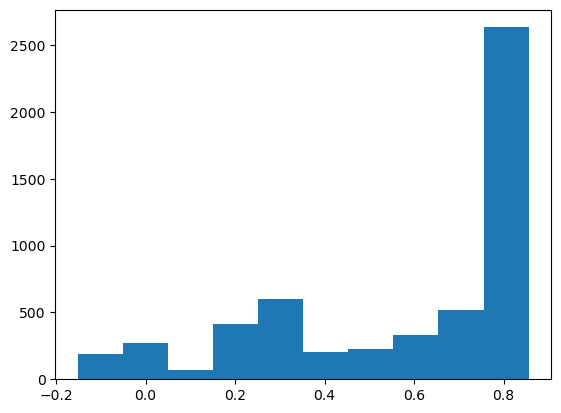

In [486]:
plt.hist(sentiments)

In [420]:
sum(df['RATING'] >7)

1687

In [421]:
sum(df['RATING'] <3)

1578

In [470]:
sentiments[:10]

[0.8370535236053169,
 0.8094770212948323,
 0.7623054913923144,
 0.47146358467573296,
 0.616762978788279,
 0.8512100743353367,
 0.7664832314308734,
 0.8370698466156608,
 0.23104079010784626,
 0.8240934974679723]

In [447]:
df['RATING'].head(10)

0    5.0
1    8.0
2    4.0
3    4.0
4    4.0
5    6.0
6    9.0
7    5.0
8    4.0
9    7.0
Name: RATING, dtype: float64

In [490]:
df[df['RATING'] == 10]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Matthew\anaconda3\Lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Matthew\anaconda3\Lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "C:\Users\Matthew\anaconda3\Lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "C:\Users\Matthew\anaconda3\Lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Matthew\anaconda3\Lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  File "C:\Users\Matthew\anaconda3\Lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "C:\Users\Matthew\anaconda3\Lib\site-packages\pandas\io\formats

        ID                                             REVIEW  RATING  \
46      47  All those that gave this less than a 5 are idi...    10.0   
69      70  If you are a heist movie fan, don't miss this ...    10.0   
89      90  Action, drama ,romance and more. I didn't have...    10.0   
94      95  I was thrilled from the beginning to the end. ...    10.0   
111    112  Much better than I expected & I've seen most o...    10.0   
...    ...                                                ...     ...   
5445  5446  It's master piece by Zack please part 2,3,4 al...    10.0   
5446  5447  No words to describe. It's awesome. One of the...    10.0   
5447  5448  Far better than previous one and better editin...    10.0   
5448  5449  Why did the studio say no to this masterpiece?...    10.0   
5449  5450  Overall Opinion-\nAlthough the competitors Mar...    10.0   

                AUTHOR                                              TITLE  
46           heliparts   All those that gave th

In [492]:
df['REVIEW'][69]

"If you are a heist movie fan, don't miss this one! A great mix of excitement, cool and genius planning and all the ups and downs executing it!"

In [493]:
df[df['RATING'] == 1]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Matthew\anaconda3\Lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Matthew\anaconda3\Lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "C:\Users\Matthew\anaconda3\Lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "C:\Users\Matthew\anaconda3\Lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Matthew\anaconda3\Lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  File "C:\Users\Matthew\anaconda3\Lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "C:\Users\Matthew\anaconda3\Lib\site-packages\pandas\io\formats

        ID                                             REVIEW  RATING  \
12      13  When u come to watch a typical shark movie , y...     1.0   
13      14  Bad CGI and rubbish story. Really!!!The female...     1.0   
16      17  Totally waste of time and money, worst movie t...     1.0   
24      25  Avoid "Great White"! It is just boring. The ch...     1.0   
32      33  Tourists charter a sea plane to visit a seclud...     1.0   
...    ...                                                ...     ...   
5375  5376  Oh my God, where to begin with this one. It ac...     1.0   
5376  5377  wow i have 2 dogs they are jack russels so the...     1.0   
5377  5378  I do'nt know why people here like this sick re...     1.0   
5380  5381  What a director tries to piggy back off a succ...     1.0   
5383  5384  Weak film. Hardly any tension, the story is to...     1.0   

                  AUTHOR                                              TITLE  
12     hossamahmed-30148                     

In [498]:
df['REVIEW'][24]

'Avoid "Great White"! It is just boring. The characters just bicker 90% of the time, I think even the shark was bored as it only turned up every now and then, before going off to probably watch paint dry or something. In fact it probably just ate people to stop then whining at each other as that is what seems to pass as "character development".'